In [2]:

##### import the necessary modules and set chart style####
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.style.use('bmh')
import pandas_datareader.data as web
import matplotlib.pylab as plt
from datetime import datetime
import statsmodels.api as sm
from pykalman import KalmanFilter
from math import sqrt


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [132]:
data = pd.read_csv("D:\Phyton\candles_AllUsd_5.csv")

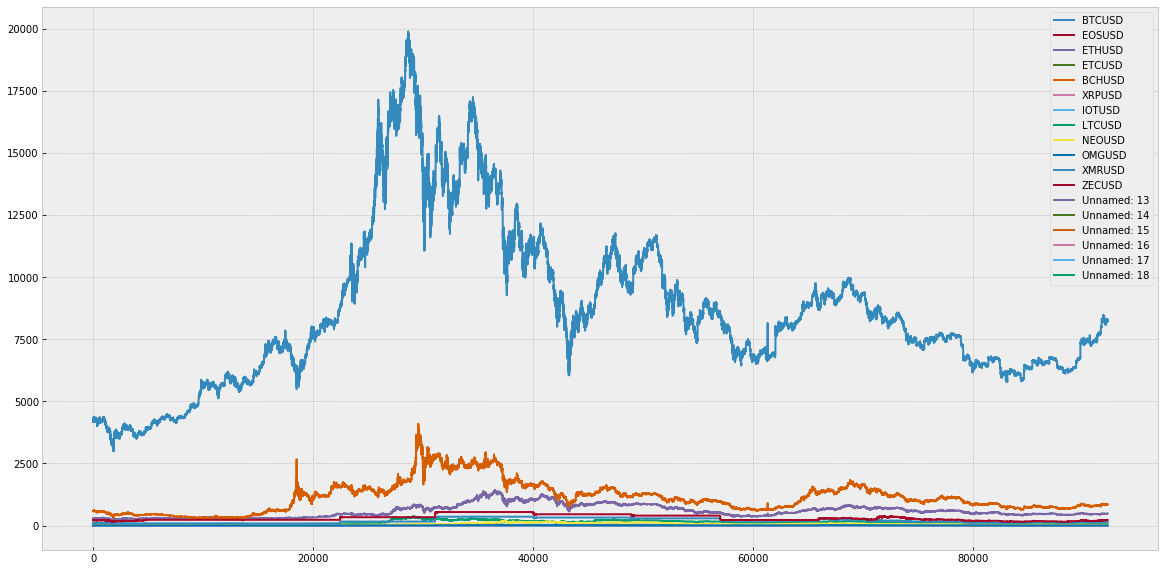

In [133]:

data.plot(figsize=(20,10))


In [137]:
df = pd.DataFrame(data[data.columns[1:13]])

In [138]:
df.tail(5)

,BTCUSD,EOSUSD,ETHUSD,ETCUSD,BCHUSD,XRPUSD,IOTUSD,LTCUSD,NEOUSD,OMGUSD,XMRUSD,ZECUSD
92251,8245.0,8.7084,479.26,16.951,848.11,0.46440,1.0332,86.926,35.260,7.3011,142.81,223.42
92252,8232.0,8.7058,479.39,16.919,847.01,0.46329,1.0325,86.794,35.140,7.3250,142.68,223.95
92253,8245.8,8.7301,480.51,16.964,847.98,0.46414,1.0415,87.046,35.187,7.3018,143.28,224.32
92254,8259.0,8.7590,481.69,17.010,851.49,0.46425,1.0451,87.203,35.225,7.3300,144.14,224.36
92255,8251.1,8.7330,481.78,17.009,850.75,0.46457,1.0411,87.128,35.217,7.3300,144.00,223.58


In [139]:

#NOTE CRITICAL LEVEL HAS BEEN SET TO 5% FOR COINTEGRATION TEST
def find_cointegrated_pairs(dataframe, critial_level = 0.1):
    n = dataframe.shape[1] # the length of dateframe
    pvalue_matrix = np.ones((n, n)) # initialize the matrix of p
    keys = dataframe.columns # get the column names
    pairs = [] # initilize the list for cointegration
    for i in range(n):
        for j in range(i+1, n): # for j bigger than i
            stock1 = dataframe[keys[i]] # obtain the price of "stock1"
            stock2 = dataframe[keys[j]]# obtain the price of "stock2"
            result = sm.tsa.stattools.coint(stock1, stock2) # get conintegration
            pvalue = result[1] # get the pvalue
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: # if p-value less than the critical level
                pairs.append((keys[i], keys[j], pvalue)) # record the contract with that p-value
    return pvalue_matrix, pairs
    

In [140]:
df.head()


,BTCUSD,EOSUSD,ETHUSD,ETCUSD,BCHUSD,XRPUSD,IOTUSD,LTCUSD,NEOUSD,OMGUSD,XMRUSD,ZECUSD
0,4250.1,0.84000,298.95,16.380,594.00,0.20999,0.52400,71.243,24.900,11.189,115.79,220.50
1,4272.9,0.83241,301.03,16.460,598.00,0.21000,0.53250,71.622,25.404,11.217,115.86,220.60
2,4304.0,0.83000,303.34,16.586,603.69,0.21077,0.53480,71.570,25.290,11.307,117.51,220.71
3,4298.7,0.82460,303.73,16.518,603.32,0.21032,0.53319,71.675,25.221,11.190,117.99,221.00
4,4306.3,0.82974,303.41,16.689,601.61,0.21140,0.53529,72.450,24.726,11.427,117.55,221.00


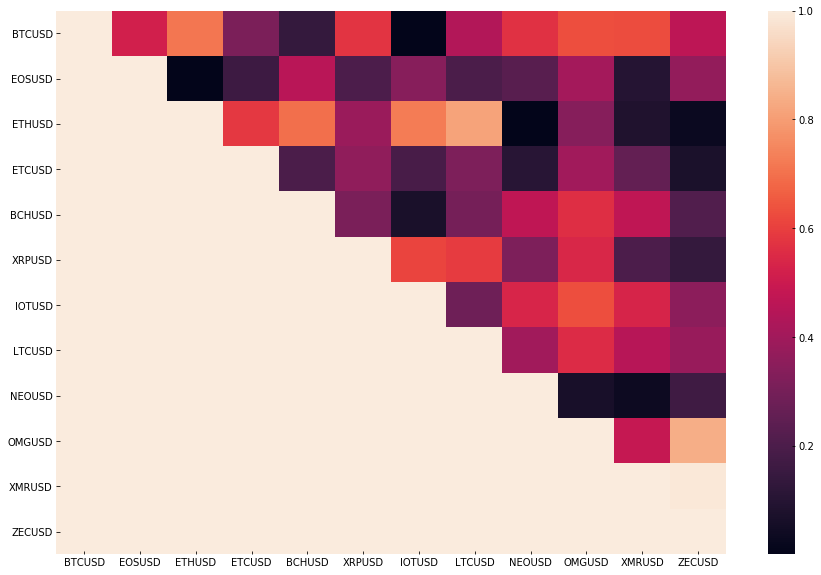

In [142]:

#set up the split point for our "training data" on which to perform the co-integration test (the remaining dat awill be fed to our backtest function)
split = int(len(df) * .68)

#run our dataframe (up to the split point) of ticker price data through our co-integration function and store results
pvalue_matrix,pairs = find_cointegrated_pairs(df[8640:split])

#convert our matrix of stored results into a DataFrame
pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

#use Seaborn to plot a heatmap of our results matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalue_matrix_df,xticklabels=data.columns[1:13],yticklabels=data.columns[1:13],ax=ax)


In [143]:
pairs

[('BTCUSD', 'IOTUSD', 0.0022523198344813074),
 ('EOSUSD', 'ETHUSD', 0.00363975873722653),
 ('EOSUSD', 'XMRUSD', 0.09999654797751556),
 ('ETHUSD', 'NEOUSD', 0.0005217037306215971),
 ('ETHUSD', 'XMRUSD', 0.08559255658746379),
 ('ETHUSD', 'ZECUSD', 0.02934397332137741),
 ('ETCUSD', 'ZECUSD', 0.07203816151867089),
 ('BCHUSD', 'IOTUSD', 0.06844904263601806),
 ('NEOUSD', 'OMGUSD', 0.06549815190528412),
 ('NEOUSD', 'XMRUSD', 0.03364818981816409)]

In [144]:

for pair in pairs:
    print("Stock {} and stock {} has a co-integration score of {}".format(pair[0],pair[1],round(pair[2],4)))


Stock BTCUSD and stock IOTUSD has a co-integration score of 0.0023
Stock EOSUSD and stock ETHUSD has a co-integration score of 0.0036
Stock EOSUSD and stock XMRUSD has a co-integration score of 0.1
Stock ETHUSD and stock NEOUSD has a co-integration score of 0.0005
Stock ETHUSD and stock XMRUSD has a co-integration score of 0.0856
Stock ETHUSD and stock ZECUSD has a co-integration score of 0.0293
Stock ETCUSD and stock ZECUSD has a co-integration score of 0.072
Stock BCHUSD and stock IOTUSD has a co-integration score of 0.0684
Stock NEOUSD and stock OMGUSD has a co-integration score of 0.0655
Stock NEOUSD and stock XMRUSD has a co-integration score of 0.0336


In [145]:

def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife


In [149]:

def backtest(df,s1, s2):
    #############################################################
    # INPUT:
    # DataFrame of prices
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two
    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: Sharpe ratio
    # CAGR: Compound Annual Growth Rate

    x = df[s1]
    y = df[s2]

    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    df1.index = pd.to_datetime(df1.index)
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################
    # trading logic
    entryZscore = 2
    exitZscore = 2

    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################
    start_val = 1
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name

    days = (end_date - start_date).days

    CAGR = round(((float(end_val) / float(start_val)) ** (252.0)) - 1,4)

    df1[s1+ " "+s2] = df1['cum rets']

    return df1[s1+" "+s2], sharpe, CAGR


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The pair BTCUSD and IOTUSD produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair EOSUSD and ETHUSD produced a Sharpe Ratio of 0.95 and a CAGR of 4.39209985470007e+94
The pair EOSUSD and XMRUSD produced a Sharpe Ratio of 0.81 and a CAGR of 5.761731650663691e+112
The pair ETHUSD and NEOUSD produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair ETHUSD and XMRUSD produced a Sharpe Ratio of 0.21 and a CAGR of 21482668.5323
The pair ETHUSD and ZECUSD produced a Sharpe Ratio of 0.07 and a CAGR of 4954.1781
The pair ETCUSD and ZECUSD produced a Sharpe Ratio of 0.92 and a CAGR of 5.408647850476854e+111
The pair BCHUSD and IOTUSD produced a Sharpe Ratio of 0.0 and a CAGR of 0.0
The pair NEOUSD and OMGUSD produced a Sharpe Ratio of 0.76 and a CAGR of 9.9190503779612e+114
The pair NEOUSD and XMRUSD produced a Sharpe Ratio of 0.88 and a CAGR of 2.522593530207369e+108


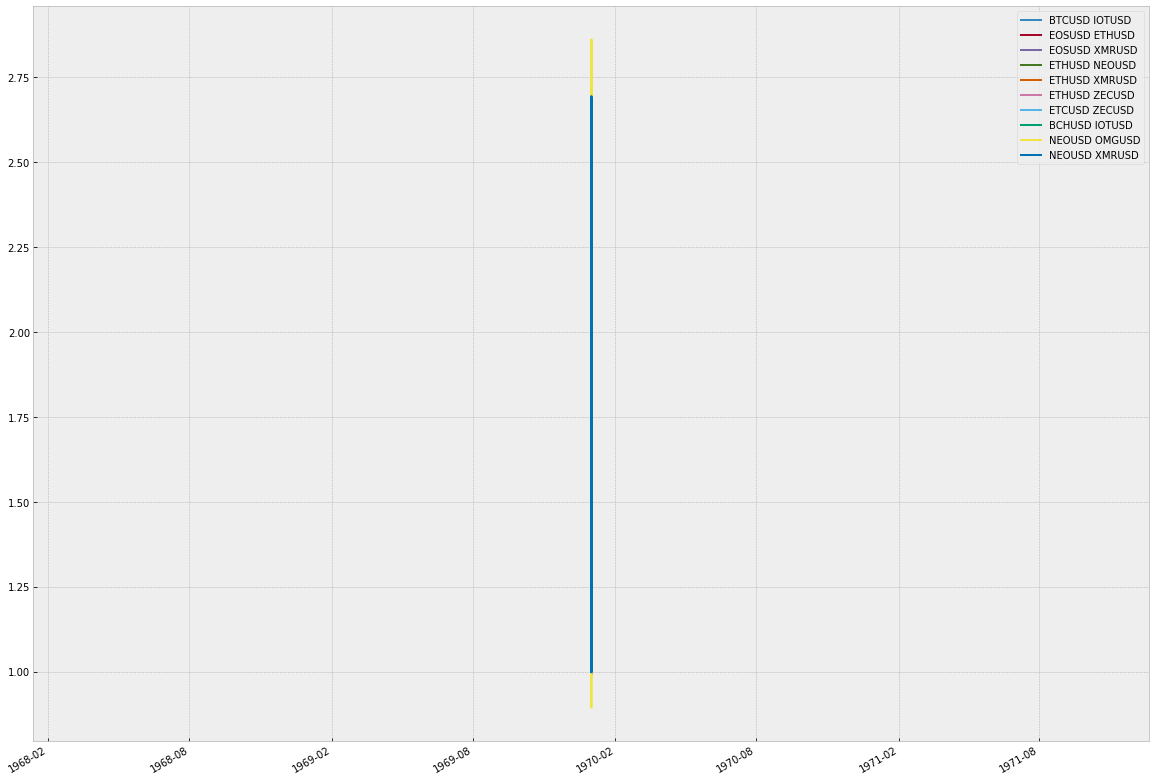

In [150]:
results = []

for pair in pairs:
    rets, sharpe,  CAGR = backtest(df[split:],pair[0],pair[1])
    results.append(rets)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR,4)))
    rets.plot(figsize=(20,15),legend=True)


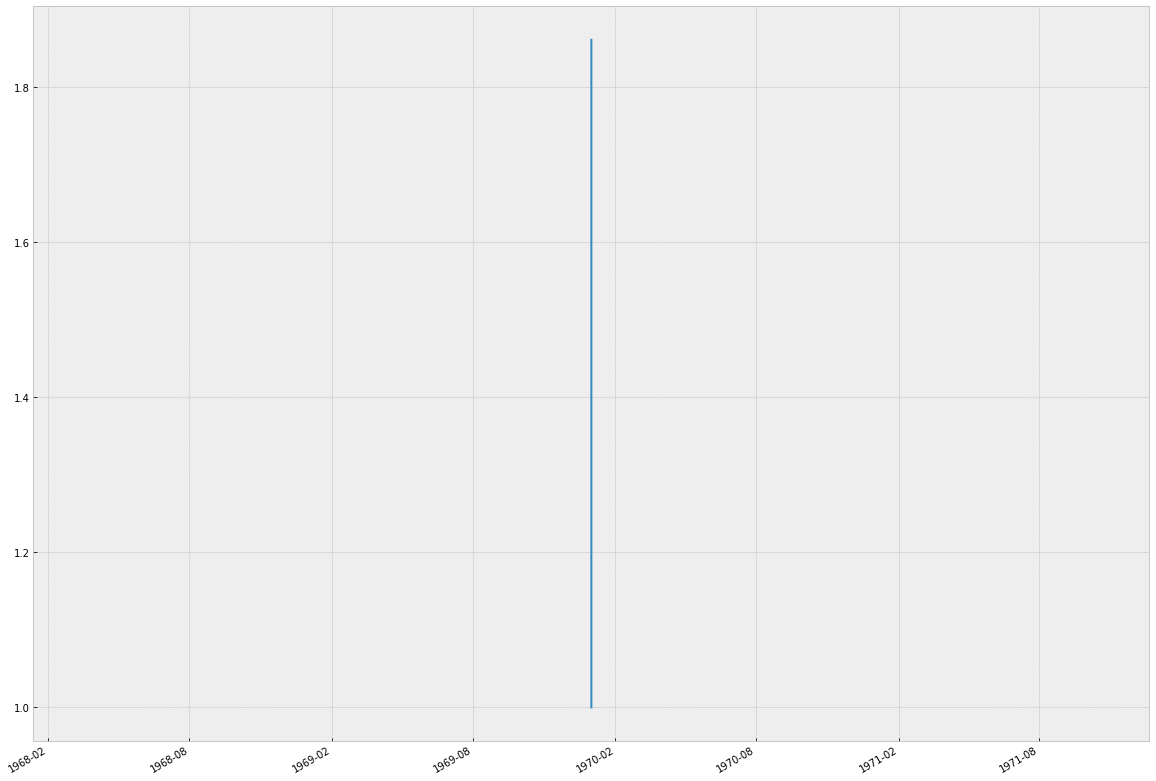

In [154]:

#concatenatge together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

#plot the chart of our final equity curve
final_res.plot(figsize=(20,15))


In [64]:
def backtest(s1, s2, x, y ):
#############################################################
# INPUT:
# s1: the symbol of contract one
# s2: the symbol of contract two
# x: the price series of contract one
# y: the price series of contract two
# OUTPUT:
# df1['cum rets']: cumulative returns in pandas data frame
# sharpe: sharpe ratio
# CAGR: CAGR

# run regression to find hedge ratio and then create spread series
df1 = pd.DataFrame({'y':y,'x':x})
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

df1['hr'] = - state_means[:,0]
df1['spread'] = df1.y + (df1.x * df1.hr)

# calculate half life
halflife = half_life(df1['spread'])

# calculate z-score with window = half life period

meanSpread = df1.spread.rolling(window=halflife).mean()
stdSpread = df1.spread.rolling(window=halflife).std()
df1['zScore'] = (df1.spread-meanSpread)/stdSpread

##############################################################
# trading logic
entryZscore = 2
exitZscore = 0

#set up num units long
df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) df1['num units long'] = np.nan df1.loc[df1['long entry'],'num units long'] = 1 df1.loc[df1['long exit'],'num units long'] = 0 df1['num units long'][0] = 0 df1['num units long'] = df1['num units long'].fillna(method='pad') #set up num units short df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
df1.loc[df1['short entry'],'num units short'] = -1
df1.loc[df1['short exit'],'num units short'] = 0
df1['num units short'][0] = 0
df1['num units short'] = df1['num units short'].fillna(method='pad')

df1['numUnits'] = df1['num units long'] + df1['num units short']
df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

df1['cum rets'] = df1['port rets'].cumsum()
df1['cum rets'] = df1['cum rets'] + 1

name = "bt"+ s1 + "-" + s2 + ".csv"
df1.to_csv(name)
##############################################################

try:
sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
except ZeroDivisionError:
sharpe = 0.0

##############################################################
start_val = 1
end_val = df1['cum rets'].iat[-1]

start_date = df1.iloc[0].name
end_date = df1.iloc[-1].name
days = (end_date - start_date).days

CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)

return df1['cum rets'], sharpe, CAGR

IndentationError: expected an indented block (<ipython-input-64-1cab61697d0c>, line 14)